In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 

import sklearn
from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble
from sklearn import tree

import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [2]:
df_master = pd.read_csv("master.csv", index_col=0)
df_master.describe()

,year,CDC Week,FIPS,Count,Disease_INFLUENZA_A,Disease_INFLUENZA_B,Disease_INFLUENZA_UNSPECIFIED,UnempRate,GDP,GDP_change,Population,flu,fluSymptoms,fever,cough,soreThroat,Target,VaxRate,PRCP,SNOW,TAVG,TMAX,TMIN,SNOWDepth,F_PRCP,F_SNOW,F_TAVG
count,20080.000000,20080.000000,20080.000000,20080.000000,20080.000000,20080.000000,20080.000000,18530.000000,7.432000e+03,5386.000000,1.778600e+04,18592.000000,18592.000000,18592.000000,18592.000000,18592.000000,19956.000000,9540.000000,20080.000000,20080.000000,20080.000000,20080.000000,20080.000000,20080.000000,19956.000000,19956.000000,19956.000000
mean,2014.174402,24.816434,36063.424900,26.010458,20.003088,5.811604,0.195767,6.718840,2.319177e+07,1.283420,3.236327e+05,0.026605,0.020833,0.287768,0.256351,0.260344,26.124424,0.555987,0.131557,0.484755,37.844781,46.809265,28.886304,2.103956,0.131296,0.487767,37.756891
std,2.992755,18.086529,35.586314,88.217416,68.727437,29.215823,1.604029,1.915021,8.214317e+07,3.383907,5.484115e+05,0.090495,0.079796,0.149518,0.178057,0.168710,88.469715,0.089235,0.130011,1.029249,13.171385,13.964036,12.856703,4.154272,0.130091,1.031730,13.161972
min,2009.000000,1.000000,36001.000000,0.000000,0.000000,0.000000,0.000000,3.300000,1.221810e+05,-9.800000,4.434000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.337000,0.000000,0.000000,-5.785714,6.375000,-23.142857,0.000000,0.000000,0.000000,-5.785714
25%,2012.000000,9.000000,36033.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.497613e+06,-0.600000,5.030000e+04,0.002475,0.001258,0.204321,0.139920,0.140832,0.000000,0.520000,0.038333,0.000000,28.250000,36.000000,20.285714,0.000000,0.038000,0.000000,28.214286
50%,2014.000000,17.000000,36065.000000,2.000000,1.000000,0.000000,0.000000,6.700000,3.190219e+06,1.300000,9.235000e+04,0.005558,0.002965,0.271068,0.221400,0.247043,2.000000,0.591000,0.100000,0.000000,37.714286,46.000000,29.285714,0.000000,0.100000,0.000000,37.571429
75%,2017.000000,44.000000,36095.000000,14.000000,10.000000,2.000000,0.000000,8.200000,1.068296e+07,3.300000,2.342030e+05,0.013376,0.008617,0.355073,0.332691,0.364779,15.000000,0.620000,0.186667,0.540000,48.214286,58.142857,38.285714,2.428571,0.185714,0.550000,48.000000
max,2019.000000,53.000000,36123.000000,2401.000000,1213.000000,1166.000000,92.000000,12.400000,6.296820e+08,12.600000,2.611232e+06,1.000000,0.915000,1.244567,1.245430,1.016013,2401.000000,0.721000,2.820000,15.000000,72.928571,85.714286,65.285714,38.285714,2.820000,15.000000,72.928571


In [3]:
columns = list(df_master.columns)
print("Columns in dataframe = ", columns)
columns_to_drop = ['FIPS', 'County Centroid', 'Disease_INFLUENZA_A','Disease_INFLUENZA_B', 'Disease_INFLUENZA_UNSPECIFIED', 'GDP', 'Population'] 
columns = [x for x in columns if x not in columns_to_drop]
print("columns = ", columns)

target_variable = 'Target'
non_features_for_model = ['Week Ending Date']
features = [x for x in columns if x not in non_features_for_model]
print("features = ", features)

Columns in dataframe =  ['County', 'year', 'CDC Week', 'FIPS', 'County Centroid', 'Week Ending Date', 'Count', 'Disease_INFLUENZA_A', 'Disease_INFLUENZA_B', 'Disease_INFLUENZA_UNSPECIFIED', 'UnempRate', 'GDP', 'GDP_change', 'Population', 'flu', 'fluSymptoms', 'fever', 'cough', 'soreThroat', 'Target', 'VaxRate', 'PRCP', 'SNOW', 'TAVG', 'TMAX', 'TMIN', 'SNOWDepth', 'Density', 'F_PRCP', 'F_SNOW', 'F_TAVG']
columns =  ['County', 'year', 'CDC Week', 'Week Ending Date', 'Count', 'UnempRate', 'GDP_change', 'flu', 'fluSymptoms', 'fever', 'cough', 'soreThroat', 'Target', 'VaxRate', 'PRCP', 'SNOW', 'TAVG', 'TMAX', 'TMIN', 'SNOWDepth', 'Density', 'F_PRCP', 'F_SNOW', 'F_TAVG']
features =  ['County', 'year', 'CDC Week', 'Count', 'UnempRate', 'GDP_change', 'flu', 'fluSymptoms', 'fever', 'cough', 'soreThroat', 'Target', 'VaxRate', 'PRCP', 'SNOW', 'TAVG', 'TMAX', 'TMIN', 'SNOWDepth', 'Density', 'F_PRCP', 'F_SNOW', 'F_TAVG']


In [4]:
df_master_modified = df_master[columns]

for column in df_master_modified.columns:
  if column not in ['Week Ending Date', 'County']:
    df_master_modified[column] = pd.to_numeric(df_master_modified[column],errors='coerce')
print("Shape of dataframe = ", df_master_modified.shape)


df_master_modified = pd.get_dummies(df_master_modified, columns=['County'])
df_master_modified.sample(8)

Shape of dataframe =  (20080, 24)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,year,CDC Week,Week Ending Date,Count,UnempRate,GDP_change,flu,fluSymptoms,fever,cough,soreThroat,Target,VaxRate,PRCP,SNOW,TAVG,TMAX,TMIN,SNOWDepth,Density,F_PRCP,F_SNOW,F_TAVG,County_ALBANY,County_ALLEGANY,County_BRONX,County_BROOME,County_CATTARAUGUS,County_CAYUGA,County_CHAUTAUQUA,County_CHEMUNG,County_CHENANGO,County_CLINTON,County_COLUMBIA,County_CORTLAND,County_DELAWARE,County_DUTCHESS,County_ERIE,County_ESSEX,County_FRANKLIN,...,County_JEFFERSON,County_KINGS,County_LEWIS,County_LIVINGSTON,County_MADISON,County_MONROE,County_MONTGOMERY,County_NASSAU,County_NEW YORK,County_NIAGARA,County_ONEIDA,County_ONONDAGA,County_ONTARIO,County_ORANGE,County_ORLEANS,County_OSWEGO,County_OTSEGO,County_PUTNAM,County_QUEENS,County_RENSSELAER,County_RICHMOND,County_ROCKLAND,County_SARATOGA,County_SCHENECTADY,County_SCHOHARIE,County_SCHUYLER,County_SENECA,County_ST LAWRENCE,County_STEUBEN,County_SUFFOLK,County_SULLIVAN,County_TIOGA,County_TOMPKINS,County_ULSTER,County_WARREN,County_WASHINGTON,County_WAYNE,County_WESTCHESTER,County_WYOMING,County_YATES
Unnamed: 0.1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8362,2010,50,12/18/2010,3,8.0,NaN,0.002660,0.001922,0.143424,0.199824,0.215160,34.0,NaN,0.026000,0.142857,23.357143,32.285714,14.428571,8.800000,1132.962067,0.033333,2.000000,24.700000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19998,2017,10,03/11/2017,3,4.4,NaN,0.008915,0.005159,0.356742,0.189064,0.196604,4.0,0.621,0.091667,0.071429,29.428571,38.142857,20.714286,4.571429,73.791921,0.101429,0.000000,30.071429,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
15180,2013,48,11/30/2013,0,8.8,-0.4,0.004122,0.000000,0.105600,0.315713,0.097158,0.0,0.505,0.267143,2.000000,21.500000,32.428571,10.571429,4.250000,56.754502,0.045000,2.450000,18.357143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11130,2013,11,03/16/2013,11,6.8,0.9,0.002695,0.002040,0.364585,0.223020,0.430950,7.0,NaN,0.231667,0.300000,35.000000,43.000000,27.000000,0.000000,461.431088,0.000000,0.096599,37.642857,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9169,2014,52,12/27/2014,214,4.8,2.4,0.024773,0.023363,0.421386,0.393636,0.610051,301.0,0.582,0.101429,0.100000,37.571429,44.000000,31.142857,1.500000,4759.163389,0.018333,0.300000,12.500000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15957,2017,1,01/07/2017,9,6.7,NaN,0.007623,0.025737,0.461039,0.520397,0.487488,27.0,0.591,0.120000,0.200000,22.000000,30.571429,13.428571,0.000000,134.030470,0.095714,0.071429,31.428571,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
13180,2014,12,03/22/2014,5,5.4,3.6,0.005111,0.007231,0.185220,0.222699,0.245805,5.0,0.623,0.055000,0.066667,26.785714,36.000000,17.571429,0.000000,244.717441,0.098571,0.014286,37.071429,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12084,2011,43,10/29/2011,0,7.7,NaN,0.002898,0.000000,0.086400,0.000000,0.083200,1.0,NaN,0.185714,0.166667,38.428571,45.142857,31.714286,0.142857,61.858840,0.074286,0.142857,46.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Handling missing data

In [5]:
def missing_data_handle(dataframe, method = "drop"):
  if method == "drop":
    dataframe_updated = dataframe.dropna()
    return dataframe_updated
  elif method == "avg_over_month":
    dataframe['Date'] = pd.to_datetime(dataframe['Week Ending Date'])
    dataframe_updated = dataframe.fillna(dataframe.groupby(dataframe.Date.dt.month).transform('mean'))
    dataframe_updated = dataframe_updated.drop(columns = ["Date"])
    return dataframe_updated
  else:
    print("Invalid method")
    return dataframe

df_master_modified = missing_data_handle(dataframe = df_master_modified, method = "avg_over_month")
df_master_modified.shape

#columns_to_remove = ['Week Ending Date']
df_master_modified = df_master_modified.drop(columns = non_features_for_model)

print(df_master_modified.shape)

(20080, 84)


Preprocessing

In [0]:
#Divide into features and dependent variable 
X = df_master_modified.copy()
X = X.drop(columns = [target_variable])
y = df_master_modified[target_variable]

#Divide into Training set and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0, shuffle = False)

#Scaling
mm_scaler = sklearn.preprocessing.MinMaxScaler()
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

Linear Regression model
with subset of features for base modeling

In [0]:
#Divide into features and dependent variable 
sub_features = ['year', 'CDC Week', 'flu','Count' ,'fluSymptoms', 'fever', 'cough', 'soreThroat','VaxRate', 'PRCP', 'SNOW', 'TAVG', 'TMAX', 'TMIN', 'SNOWDepth', 'Density']
X_sub = df_master_modified[sub_features]
y_sub = df_master_modified[target_variable]

#Divide into Training set and test set
X_train_sub, X_test_sub, y_train_sub, y_test_sub = model_selection.train_test_split(X_sub, y_sub, test_size=0.2, random_state=0, shuffle = False)

#Scaling
mm_scaler = sklearn.preprocessing.MinMaxScaler()
X_train_scaled_sub = mm_scaler.fit_transform(X_train_sub)
X_test_scaled_sub = mm_scaler.transform(X_test_sub)

In [63]:
def pred_model_regr_sub(X_train, y_train, X_test, y_test ):
  model_regr = linear_model.LinearRegression()
  model_regr.fit(X_train, y_train)
  y_pred_regression = model_regr.predict(X_test)
  Test_r2_score_regression = metrics.r2_score(y_test, y_pred_regression)
  print("R2 Score for Regression on testing data = {}" .format(Test_r2_score_regression * 100))

  y_train_pred_regression = model_regr.predict(X_train)
  Train_r2_score_regression = metrics.r2_score(y_train, y_train_pred_regression)
  print("R2 Score for Regression on training data = {}" .format(Train_r2_score_regression * 100))

  return model_regr, Test_r2_score_regression, Train_r2_score_regression


model_regr, regr_test_score_sub, regr_train_score_sub = pred_model_regr_sub(X_train_scaled_sub, y_train_sub, X_test_scaled_sub, y_test_sub )

R2 Score for Regression on testing data = 70.15931237533249
R2 Score for Regression on training data = 68.97415779386931


Test R2 value is too low, opting for regularization 
LASSO penalizes features to zero if not required but Ridge does not penalize the feature to zero but minimizes them if required

Ridge Regression

In [60]:
def pred_model_ridge_sub(X_train, y_train, X_test, y_test ):
  model_ridge = linear_model.Ridge(alpha = 0.8)
  model_ridge.fit(X_train, y_train)
  y_pred_ridge = model_ridge.predict(X_test)
  Test_r2_score_ridge = metrics.r2_score(y_test, y_pred_ridge)
  print("R2 Score for Ridge Regression with subset features on testing data = {}" .format(Test_r2_score_ridge * 100))

  y_train_pred_ridge = model_ridge.predict(X_train)
  Train_r2_score_ridge = metrics.r2_score(y_train, y_train_pred_ridge)
  print("R2 Score for Ridge Regression with subset features on training data = {}" .format(Train_r2_score_ridge * 100))

  return model_ridge, Test_r2_score_ridge, Train_r2_score_ridge


model_ridge, ridge_test_score_sub, ridge_train_score_sub = pred_model_ridge_sub(X_train_scaled_sub, y_train_sub, X_test_scaled_sub, y_test_sub )

R2 Score for Ridge Regression with subset features on testing data = 11.302755425085664
R2 Score for Ridge Regression with subset features on training data = 18.20783024272179


All the features

In [62]:
def pred_model_regr(X_train, y_train, X_test, y_test ):
  model_regr = linear_model.LinearRegression()
  model_regr.fit(X_train, y_train)
  y_pred_regression = model_regr.predict(X_test)
  Test_r2_score_regression = metrics.r2_score(y_test, y_pred_regression)
  print("R2 Score for Regression on testing data = {}" .format(Test_r2_score_regression * 100))

  y_train_pred_regression = model_regr.predict(X_train)
  Train_r2_score_regression = metrics.r2_score(y_train, y_train_pred_regression)
  print("R2 Score for Regression on training data = {}" .format(Train_r2_score_regression * 100))

  return model_regr, Test_r2_score_regression, Train_r2_score_regression


model_regr, regr_test_score, regr_train_score = pred_model_regr(X_train_scaled, y_train, X_test_scaled, y_test )

R2 Score for Regression on testing data = -1.8179189908800975e+25
R2 Score for Regression on training data = 69.71746849493026


In [51]:
def pred_model_ridge(X_train, y_train, X_test, y_test ):
  model_ridge = linear_model.Ridge(alpha = 0.2)
  model_ridge.fit(X_train, y_train)
  y_pred_ridge = model_ridge.predict(X_test)
  Test_r2_score_ridge = metrics.r2_score(y_test, y_pred_ridge)
  print("R2 Score for Ridge Regression on testing data = {}" .format(Test_r2_score_ridge * 100))

  y_train_pred_ridge = model_ridge.predict(X_train)
  Train_r2_score_ridge = metrics.r2_score(y_train, y_train_pred_ridge)
  print("R2 Score for Ridge Regression on training data = {}" .format(Train_r2_score_ridge * 100))

  return model_ridge, Test_r2_score_ridge, Train_r2_score_ridge


model_ridge, ridge_test_score, ridge_train_score = pred_model_ridge(X_train_scaled, y_train, X_test_scaled, y_test )

R2 Score for Ridge Regression on testing data = 69.13209195000165
R2 Score for Ridge Regression on training data = 69.71101540086539


Ridge Regression with all features

In [0]:
def pred_model_ridge(X_train, y_train, X_test, y_test ):
  model_ridge = linear_model.Ridge(alpha = 0.2)
  model_ridge.fit(X_train, y_train)
  y_pred_ridge = model_ridge.predict(X_test)
  Test_r2_score_ridge = metrics.r2_score(y_test, y_pred_ridge)
  print("R2 Score for Ridge Regression on testing data = {}" .format(Test_r2_score_ridge * 100))

  y_train_pred_ridge = model_ridge.predict(X_train)
  Train_r2_score_ridge = metrics.r2_score(y_train, y_train_pred_ridge)
  print("R2 Score for Ridge Regression on training data = {}" .format(Train_r2_score_ridge * 100))

  return model_ridge, Test_r2_score_ridge, Train_r2_score_ridge


model_ridge, ridge_test_score, ridge_train_score = pred_model_ridge(X_train_scaled, y_train, X_test_scaled, y_test )

Stochastic Gradient Descent

In [8]:
def pred_model_sgd(X_train, y_train, X_test, y_test):
  model_sgd = linear_model.SGDRegressor()
  model_sgd.fit(X_train, y_train)
  y_train_pred_sgd = model_sgd.predict(X_test)
  Test_r2_score_sgd = metrics.r2_score(y_test, y_train_pred_sgd)
  print("R2 Score for Stochastic Gradient Descent on testing data = {}" .format(Test_r2_score_sgd * 100))

  y_train_pred_sgd = model_sgd.predict(X_train)
  Train_r2_score_sgd = metrics.r2_score(y_train, y_train_pred_sgd)
  print("R2 Score for Stochastic Gradient Descent on training data = {}" .format(Train_r2_score_sgd * 100))

  return model_sgd, Test_r2_score_sgd, Train_r2_score_sgd

model_sgd, sgd_test_score, sgd_test_score = pred_model_sgd(X_train_scaled, y_train, X_test_scaled, y_test )

R2 Score for Stochastic Gradient Descent on testing data = 64.92804876696685
R2 Score for Stochastic Gradient Descent on training data = 68.22002575429924


SVM




In [52]:
def pred_model_SVM(X_train, y_train, X_test, y_test):
  model_svm = svm.SVR(max_iter= 1000000)
  model_svm.fit(X_train, y_train)
  y_train_pred_svm = model_svm.predict(X_test)
  Test_r2_score_svm = metrics.r2_score(y_test, y_train_pred_svm)
  print("R2 Score for Support Vector Machine on testing data = {}" .format(Test_r2_score_svm * 100))

  y_train_pred_svm = model_svm.predict(X_train)
  Train_r2_score_svm = metrics.r2_score(y_train, y_train_pred_svm)
  print("R2 Score for Support Vector Machine on training data = {}" .format(Train_r2_score_svm * 100))

  return model_svm, Test_r2_score_svm, Train_r2_score_svm

model_svm, svm_test_score, svm_train_score = pred_model_SVM(X_train_scaled, y_train, X_test_scaled, y_test )

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


R2 Score for Support Vector Machine on testing data = -2.8370835857369325
R2 Score for Support Vector Machine on training data = -1.0102839963120225


Decision Trees

In [10]:
def pred_model_dt(X_train, y_train, X_test, y_test):
  model_dt = tree.DecisionTreeRegressor()
  model_dt.fit(X_train, y_train)
  y_pred_decisionTree = model_dt.predict(X_test)
  Test_r2_score_decisionTree = metrics.r2_score(y_test, y_pred_decisionTree)
  print("R2 Score for Decision Tree on testing data = {}" .format(Test_r2_score_decisionTree * 100))

  y_train_pred_regression = model_dt.predict(X_train)
  Train_r2_score_decisionTree = metrics.r2_score(y_train, y_train_pred_regression)
  print("R2 Score for Decision Tree on training data = {}" .format(Train_r2_score_decisionTree * 100))

  return model_dt, Test_r2_score_decisionTree, Train_r2_score_decisionTree

model_dt, dt_test_score, dt_train_score = pred_model_dt(X_train_scaled, y_train, X_test_scaled, y_test)

R2 Score for Decision Tree on testing data = 69.3106026992959
R2 Score for Decision Tree on training data = 100.0


As the R2 score on training data is much better than testing data, we can say that our model suffers from "High Variance"

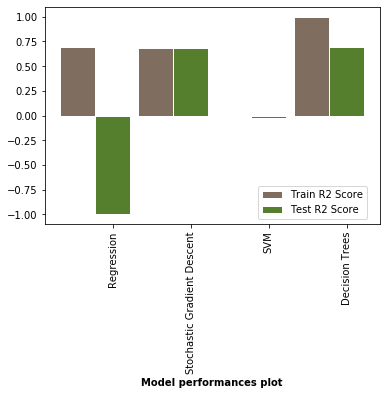

In [72]:
model_scores = {
    "Regression": [regr_test_score, regr_train_score],
    "Stochastic Gradient Descent": [sgd_test_score, sgd_test_score],
    "SVM": [svm_test_score, svm_train_score],
    "Decision Trees": [dt_test_score, dt_train_score]}

barWidth = 0.45

r1 = np.arange(len(model_scores.keys()))
r2 = [x + barWidth for x in r1]

plt.bar(r1, [value[1] for key, value in model_scores.items()], color='#7f6d5f', width=barWidth, edgecolor='white', label='Train R2 Score')
plt.bar(r2, [max(value[0], -1) for key, value in model_scores.items()], color='#557f2d', width=barWidth, edgecolor='white', label='Test R2 Score')

plt.xlabel('Model performances plot', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(model_scores.keys()))], [key for key, value in model_scores.items()], rotation = 90)


plt.legend(loc=9, bbox_to_anchor=(0.8,0.2))
plt.show()

feature_importance =  [1.16967965e-02 9.66075446e-02 7.33544910e-01 3.62049335e-03
 1.36411708e-03 4.32800093e-03 1.16714847e-02 7.72436809e-03
 9.75226563e-03 1.09234281e-02 8.89786897e-03 1.43099672e-02
 6.90954009e-03 4.29900144e-03 1.10596978e-02 2.90200330e-03
 1.16767281e-02 1.33854477e-02 3.75047945e-03 3.50529046e-03
 1.34579732e-02 1.77567147e-04 1.66043194e-05 1.56619767e-04
 1.08110983e-03 8.57788152e-06 1.25266485e-04 6.55854672e-05
 3.83966284e-05 6.07624300e-06 6.46805405e-06 3.55369011e-06
 8.70412448e-06 1.17963070e-05 8.15833171e-05 1.92303040e-04
 2.14504374e-06 3.47434014e-06 5.02600316e-07 5.89335860e-06
 4.14079267e-06 5.04887136e-07 2.67040876e-05 1.60372573e-04
 3.33165901e-03 1.04936173e-06 6.65650825e-05 6.61648283e-06
 4.40740378e-03 3.43391578e-06 2.60412693e-04 8.60329536e-04
 2.73505655e-05 8.19782722e-04 7.25538053e-04 3.91883004e-05
 9.44686618e-05 2.38489862e-06 4.18578903e-05 9.46762509e-06
 1.94928783e-05 1.02696203e-03 6.30487968e-05 1.89933520e-05
 2

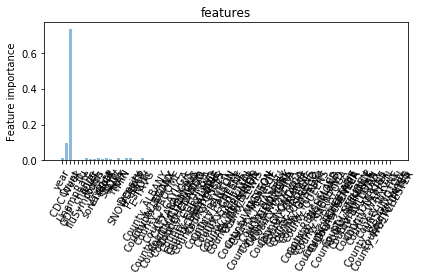

In [12]:
feature_importance = model_dt.feature_importances_
feature_importance_sorted = (np.sort(feature_importance))[::-1]
print("feature_importance = ", feature_importance)

y_pos = np.arange(len(feature_importance))
plt.bar(y_pos,feature_importance, align='center', alpha=0.5)
plt.xticks(y_pos, X_train.columns[:len(feature_importance)])
plt.ylabel('Feature importance')
plt.title('features')
plt.xticks(rotation=60)

#plt.rcParams['figure.figsize'] = 50, 100
plt.tight_layout()

plt.show()


Selecting best min sample leaf values and min sample split values for decision trees

In [13]:
min_samples_split_values = [int(i) for i in np.logspace(1, 12, num=10, base=2)]
min_samples_leaf_values = [int(i) for i in np.logspace(1, 12, num=10, base=2)]

def testTrees(x_train, x_test, y_train, y_test, split, leaf):
    '''
    Build a function that takes in tree hyperparams, data and returns accuracy on test data
    '''
    model = tree.DecisionTreeRegressor(criterion='mse',min_samples_leaf = leaf, min_samples_split = split)
    
    model.fit(x_train,y_train)
    test_p = model.predict(x_test)
    train_p = model.predict(x_train)
    
    test_r2_score = metrics.r2_score(y_test, test_p)
    train_r2_score = metrics.r2_score(y_train, train_p)

    return train_r2_score, test_r2_score
 
res = dict()
train_res = dict()
for s in min_samples_leaf_values:
    res[s] = list()
    train_res[s] = list()

for l in min_samples_leaf_values:
    for s in min_samples_split_values:
        train_r2_score, test_r2_score = testTrees(X_train_scaled, X_test_scaled, y_train, y_test, s, l)
        res[s].append(test_r2_score)
        train_res[s].append(train_r2_score)

#To get the best test score
maximum = max(res, key=res.get)
print("min sample leaf value = {}, sample split value = {} for the best R2 score = {}" .format(s ,res[maximum].index(max(res[maximum])) , max(res[maximum]) * 100))
#To get train value corresponding to best test result
optim_dt_test_score = max(res[maximum])
optim_dt_train_score = train_res[maximum][res[maximum].index(max(res[maximum]))]
print("Train R2 score corresponding to best test result = " ,train_res[maximum][res[maximum].index(max(res[maximum]))] * 100)

min sample leaf value = 4096, sample split value = 2 for the best R2 score = 80.55169654718787
Train R2 score corresponding to best test result =  89.54095674190137


We can see that the train R2 score is still higher than test score. This could be made better using ensember model

Text(0.5, 1.0, 'Holdout Accuracy by Hyperparameters')

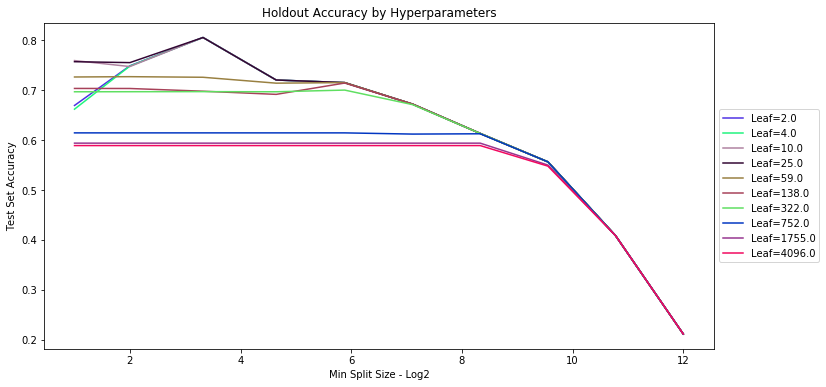

In [14]:
def r():
    return np.random.rand()

fig = plt.figure(figsize = (15, 6))
ax = fig.add_subplot(111)

for l in min_samples_leaf_values:
    plt.plot(np.log2(min_samples_split_values), res[l], 
             color=(r(),r(),r()), label='Leaf={}'.format(np.floor(l)))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Min Split Size - Log2')
ax.set_ylabel('Test Set Accuracy')
plt.title('Holdout Accuracy by Hyperparameters')

In [15]:
def pred_model_rf(X_train, y_train, X_test, y_test):
  model_rf = ensemble.RandomForestRegressor(n_estimators = 500)
  model_rf.fit(X_train, y_train)
  y_train_pred_randomForest = model_rf.predict(X_test)
  Test_r2_score_randomForest = metrics.r2_score(y_test, y_train_pred_randomForest)
  print("R2 Score for Random Forest on testing data = {}" .format(Test_r2_score_randomForest * 100))

  y_train_pred_randomForest = model_rf.predict(X_train)
  Train_r2_score_randomForest = metrics.r2_score(y_train, y_train_pred_randomForest)
  print("R2 Score for Random Forest on training data = {}" .format(Train_r2_score_randomForest * 100))

  return model_rf, Test_r2_score_randomForest, Train_r2_score_randomForest


model_rf, rf_test_score, rf_train_score = pred_model_rf(X_train_scaled, y_train, X_test_scaled, y_test )

R2 Score for Random Forest on testing data = 86.25542405840562
R2 Score for Random Forest on training data = 98.39094998425783


In [16]:
#Hyperparameter tuning
def pred_model_rf_hp_tuning(X_train, y_train, X_test, y_test):
  best_test_Score = 0
  for estimator in range(100,1100,200):
    model_rf = ensemble.RandomForestRegressor(n_estimators = estimator)
    model_rf.fit(X_train, y_train)
    y_train_pred_randomForest = model_rf.predict(X_test)
    Test_r2_score_randomForest = metrics.r2_score(y_test, y_train_pred_randomForest)
    print("R2 Score for Random Forest on testing data = {} for estimator = {}" .format(Test_r2_score_randomForest * 100, estimator))

    y_train_pred_randomForest = model_rf.predict(X_train)
    Train_r2_score_randomForest = metrics.r2_score(y_train, y_train_pred_randomForest)
    print("R2 Score for Random Forest on training data = {}  for estimator = {}" .format(Train_r2_score_randomForest * 100, estimator))

    if best_test_Score < Test_r2_score_randomForest:
      best_test_Score = Test_r2_score_randomForest
      optimum_estimator = estimator

  return optimum_estimator

optimum_estimator = pred_model_rf_hp_tuning(X_train_scaled, y_train, X_test_scaled, y_test )
print("Optimum Estimator Value= ",optimum_estimator )

R2 Score for Random Forest on testing data = 86.15858178009225 for estimator = 100
R2 Score for Random Forest on training data = 98.24380279708166  for estimator = 100
R2 Score for Random Forest on testing data = 86.37854573200052 for estimator = 300
R2 Score for Random Forest on training data = 98.29602211027839  for estimator = 300
R2 Score for Random Forest on testing data = 86.71139344623136 for estimator = 500
R2 Score for Random Forest on training data = 98.33607946654921  for estimator = 500
R2 Score for Random Forest on testing data = 86.723570097504 for estimator = 700
R2 Score for Random Forest on training data = 98.35881413445108  for estimator = 700
R2 Score for Random Forest on testing data = 86.57261165058839 for estimator = 900
R2 Score for Random Forest on training data = 98.36762486872162  for estimator = 900
Optimum Estimator Value=  700


K fold Cross Validation

In [17]:
n_splits = 5
tscv = model_selection.TimeSeriesSplit(n_splits=n_splits)
split_number = 0
best_r2_test = 0

r2_score_cv = []
for train_index, test_index in tscv.split(X):
  split_number += 1
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
  y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

  mm_scaler = sklearn.preprocessing.MinMaxScaler()
  X_train_cv_scaled = mm_scaler.fit_transform(X_train_cv)
  X_test_cv_scaled = mm_scaler.transform(X_test_cv)

  model_rf = sklearn.ensemble.RandomForestRegressor(n_estimators = optimum_estimator)
  model_rf.fit(X_train_cv_scaled, y_train_cv)
  y_train_pred_randomForest = model_rf.predict(X_test_cv_scaled)
  Test_r2_score_randomForest = metrics.r2_score(y_test_cv, y_train_pred_randomForest)
  print("R2 Score for Random Forest on testing data = {} for split number = {}" .format(Test_r2_score_randomForest * 100, split_number))

  y_train_pred_randomForest = model_rf.predict(X_train_cv_scaled)
  Train_r2_score_randomForest = metrics.r2_score(y_train_cv, y_train_pred_randomForest)
  print("R2 Score for Random Forest on training data = {} for split number = {}" .format(Train_r2_score_randomForest * 100, split_number))

  r2_score_cv.append(Test_r2_score_randomForest)

  if Test_r2_score_randomForest > best_r2_test:
    best_r2_test = Test_r2_score_randomForest
    best_r2_train = Train_r2_score_randomForest
    best_split_model = copy.deepcopy(model_rf)
    best_split_X_train = X_train_cv.copy()
    best_split_X_test = y_train_cv.copy()

print("R2 Score for the best Random Forest model on testing data = {}" .format(best_r2_test * 100))

R2 Score for Random Forest on testing data = 68.97991196552198 for split number = 1
R2 Score for Random Forest on training data = 96.4449006591406 for split number = 1
R2 Score for Random Forest on testing data = 78.7586542157921 for split number = 2
R2 Score for Random Forest on training data = 96.67042701812677 for split number = 2
R2 Score for Random Forest on testing data = 87.45288740057356 for split number = 3
R2 Score for Random Forest on training data = 98.06644509761556 for split number = 3
R2 Score for Random Forest on testing data = 79.93835440899883 for split number = 4
R2 Score for Random Forest on training data = 98.37473826897238 for split number = 4
R2 Score for Random Forest on testing data = 91.28970870384587 for split number = 5
R2 Score for Random Forest on training data = 98.36394830738872 for split number = 5
R2 Score for the best Random Forest model on testing data = 91.28970870384587


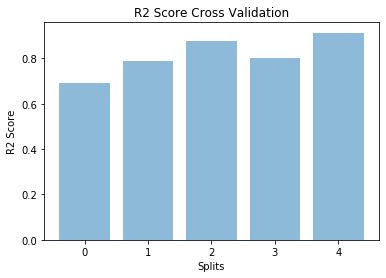

In [18]:
y_pos = np.arange(n_splits)
plt.bar(y_pos,r2_score_cv, align='center', alpha=0.5)
plt.xticks(y_pos,range(n_splits))
plt.ylabel('R2 Score')
plt.xlabel('Splits')
plt.title('R2 Score Cross Validation')

plt.show()

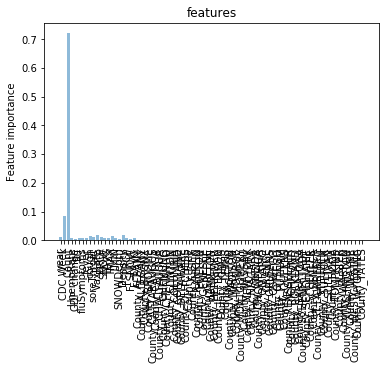

<Figure size 3600x2160 with 0 Axes>

In [36]:
extended_feature_importance = model_rf.feature_importances_

extended_feature_dict = {}
for i in range(len(feature_importance)):
  extended_feature_dict[list(X.columns)[i]] = extended_feature_importance[i]

y_pos = np.arange(len(extended_feature_importance))
plt.bar(y_pos,extended_feature_importance, align='center', alpha=0.5)
plt.xticks(y_pos, X_train.columns[:len(feature_importance)])
plt.ylabel('Feature importance')
plt.title('features')
plt.xticks(rotation=90)

plt.figure(figsize=(50,30))
#plt.tight_layout()

plt.show()

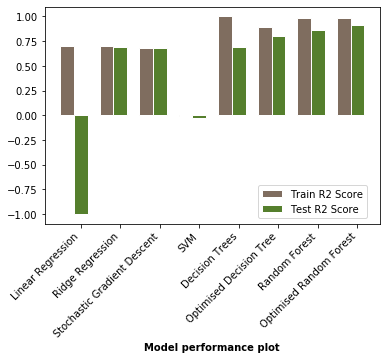

In [71]:
extended_model_scores = {
    "Linear Regression": [regr_test_score, regr_train_score],
    "Ridge Regression" : [ridge_test_score, ridge_train_score],
    "Stochastic Gradient Descent": [sgd_test_score, sgd_test_score],
    "SVM": [svm_test_score, svm_train_score],
    "Decision Trees": [dt_test_score, dt_train_score], 
    "Optimised Decision Tree": [optim_dt_test_score, optim_dt_train_score],
    "Random Forest": [rf_test_score, rf_train_score],
    "Optimised Random Forest" : [best_r2_test ,best_r2_train]}

barWidth = 0.35

r1 = np.arange(len(extended_model_scores.keys()))
r2 = [x + barWidth for x in r1]

plt.bar(r1, [value[1] for key, value in extended_model_scores.items()], color='#7f6d5f', width=barWidth, edgecolor='white', label='Train R2 Score')
plt.bar(r2, [max(value[0],-1) for key, value in extended_model_scores.items()], color='#557f2d', width=barWidth, edgecolor='white', label='Test R2 Score')

plt.xlabel('Model performance plot', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(extended_model_scores.keys()))], [key for key, value in extended_model_scores.items()], rotation = 45, ha = 'right')
 
plt.legend(loc=9, bbox_to_anchor=(0.8,0.2))
plt.show()